In [9]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# modelo
m = 1
# tamanho da janela deslizante
n = 3
# ataque
at = 8
veremiPath = "/content/drive/MyDrive/dataset/veremi"
t2Path = "/veremiWithT2"
simcsvPath = '/simulationscsv'
window = "/window"+str(n)+"v2"
model = "/model"+str(m)
preprocessing = "/preprocessing"
atk = "/atk"+str(at)
lstmPath = '/lstm'
lstmunits = 32

os.chdir(veremiPath+t2Path+window+model+'/allscenarios2')
multi = pd.read_csv('allsc2.csv', index_col=0)

# os.chdir(veremiPath+t2Path+window+lstmPath+model+atk)
# os.listdir()


In [ ]:
# WithRSSI
# transformar os demais ataques em label 0
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
df = multi
df.iloc[:, -1].loc[df.iloc[:, -1] != at] = 0
# df.iloc[:, -1].unique()
# split data and label
data = df.iloc[:, 0:-1].values
classes = df.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.classes_
classes = lb.transform(classes)
classes = MultiLabelBinarizer().fit_transform(classes)
# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, test_size=0.2, random_state=1)
data_train=data_train.reshape(data_train.shape[0], int(data_train.shape[1]/2), 2)
data_test=data_test.reshape(data_test.shape[0], int(data_test.shape[1]/2), 2)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)

data_train (14817733, 3, 2)
data_test (3704434, 3, 2)
classes_train (14817733, 2)
classes_test (3704434, 2)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
layer1 = keras.Input(shape=(data_train.shape[1], data_train.shape[2]))
layer2 = keras.layers.LSTM(lstmunits, return_sequences=True)(layer1)
layer3 = keras.layers.LSTM(lstmunits)(layer2)
output = keras.layers.Dense(classes_train.shape[1], activation="softmax")(layer3)
modellstm = keras.Model(inputs=layer1, outputs=output, name='model'+str(m)+'lstm')
print(modellstm.summary())
modellstm.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.Recall(class_id=1)],
)
start_time = time.time()
early_stopping = EarlyStopping(
    monitor="loss",
    patience=3,
    min_delta=1e-4,
    restore_best_weights=True
)
modellstm.fit(
    data_train,
    classes_train,
    epochs=200,
    batch_size=1000,
    callbacks=[early_stopping]
)
print('Done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
modellstm.save(veremiPath+t2Path+window+lstmPath+model+atk+'/withrssi')

Model: "model1lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 12,866
Trainable params: 12,866
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14818/14818 [==============================] - 411s 27ms/step - loss: 0.1110 - binary_accuracy: 0.9617 - recall: 0.1065
Epoch 2/200
14818/14818 [======================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/dataset/veremi/veremiWithT2/window3v2/lstm/model1/atk8/withrssi/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/dataset/veremi/veremiWithT2/window3v2/lstm/model1/atk8/withrssi/assets


Best Threshold=0.061418, F-Score=0.457
----------------------------------------------------------------------
Classification Report for md1lstmat8withrssi
              precision    recall  f1-score   support

   class all      0.982     0.962     0.972   3559276
     class 8      0.382     0.569     0.457    145158

    accuracy                          0.947   3704434
   macro avg      0.682     0.766     0.715   3704434
weighted avg      0.959     0.947     0.952   3704434

----------------------------------------------------------------------


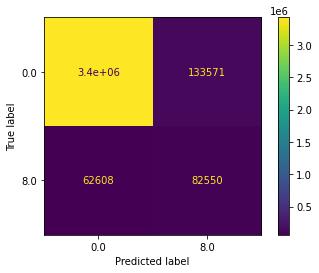

----------------------------------------------------------------------


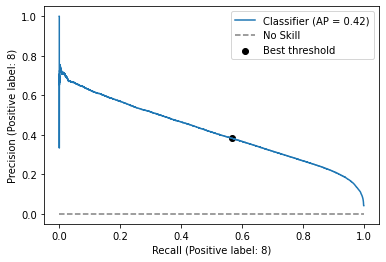

----------------------------------------------------------------------


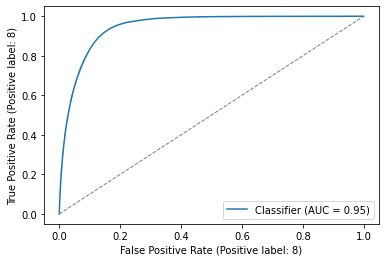

In [ ]:
# with RSSI
# metrics
clTest = lb.inverse_transform(classes_test)
os.chdir(veremiPath+t2Path+window+lstmPath+model+atk+'/withrssi')
modellstm = keras.models.load_model(veremiPath+t2Path+window+lstmPath+model+atk+'/withrssi')
proba = modellstm.predict(data_test)
# Best threshold
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(clTest, proba[:, 1], pos_label=at)
# convert to f score
np.seterr(divide='ignore', invalid='ignore')
fscore = (2 * precision * recall) / (precision + recall)
np.nan_to_num(fscore, copy=False)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print("-"*70)
# Classification Report
from sklearn.metrics import classification_report
pred = np.where(np.array(proba[:, 1]) >= thresholds[ix], at, 0)
print('Classification Report for md'+str(m)+'lstm'+'at'+str(at)+'withrssi')
print(classification_report(clTest, pred, target_names=['class all', 'class '+str(at)], digits=3, zero_division=0))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# predrelu = lb.inverse_transform(predictsrelu, threshold=thresholds[ix])
cm = confusion_matrix(clTest, pred, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.savefig('md'+str(m)+'lstm'+'at'+str(at)+'withrssi'+'.pdf')
plt.show()
print("-"*70)
# Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(clTest, proba[:, 1], pos_label=at)
# plt.title('PR curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
no_skill = len(clTest[clTest==1]) / len(clTest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', color="grey", label='No Skill')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold')
plt.legend()
plt.savefig('PRcurve '+'md'+str(m)+'lstm'+'at'+str(at)+'withrssi'+'.pdf')
plt.show()
print("-"*70)
# ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(clTest, proba[:, 1], pos_label=at)
# plt.title('ROC curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.savefig('ROCcurve '+'md'+str(m)+'lstm'+'at'+str(at)+'withrssi'+'.pdf')
plt.show()

In [11]:
# retirar o RSSI
df = multi[['0', '2', '4', '6']]
# transformar os demais ataques em label 0
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
df.iloc[:, -1].loc[df.iloc[:, -1] != at] = 0
# split data and label
data = df.iloc[:, 0:-1].values
classes = df.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.classes_
classes = lb.transform(classes)
classes = MultiLabelBinarizer().fit_transform(classes)
# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, test_size=0.2, random_state=1)
data_train=data_train.reshape(data_train.shape[0], data_train.shape[1], 1)
data_test=data_test.reshape(data_test.shape[0], data_train.shape[1], 1)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)

data_train (14817733, 3, 1)
data_test (3704434, 3, 1)
classes_train (14817733, 2)
classes_test (3704434, 2)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
layer1 = keras.Input(shape=(data_train.shape[1], data_train.shape[2]))
layer2 = keras.layers.LSTM(lstmunits, return_sequences=True)(layer1)
layer3 = keras.layers.LSTM(lstmunits)(layer2)
output = keras.layers.Dense(classes_train.shape[1], activation="softmax")(layer3)
modellstm = keras.Model(inputs=layer1, outputs=output, name='model'+str(m)+'lstm')
print(modellstm.summary())
modellstm.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.Recall(class_id=1)],
)
start_time = time.time()
early_stopping = EarlyStopping(
    monitor="loss",
    patience=3,
    min_delta=1e-4,
    restore_best_weights=True
)
modellstm.fit(
    data_train,
    classes_train,
    epochs=200,
    batch_size=1000,
    callbacks=[early_stopping]
)
print('Done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
modellstm.save(veremiPath+t2Path+window+lstmPath+model+atk+'/onlydist')

Model: "model1lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 32)             4352      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 12,738
Trainable params: 12,738
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14818/14818 [==============================] - 390s 26ms/step - loss: 0.1120 - binary_accuracy: 0.9618 - recall_1: 0.1193
Epoch 2/200
14818/14818 [====================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/dataset/veremi/veremiWithT2/window3v2/lstm/model1/atk8/onlydist/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/dataset/veremi/veremiWithT2/window3v2/lstm/model1/atk8/onlydist/assets


Best Threshold=0.103673, F-Score=0.458
----------------------------------------------------------------------
Classification Report for md1lstmat8onlydist
              precision    recall  f1-score   support

   class all      0.981     0.968     0.974   3559276
     class 8      0.402     0.533     0.458    145158

    accuracy                          0.951   3704434
   macro avg      0.691     0.750     0.716   3704434
weighted avg      0.958     0.951     0.954   3704434

----------------------------------------------------------------------


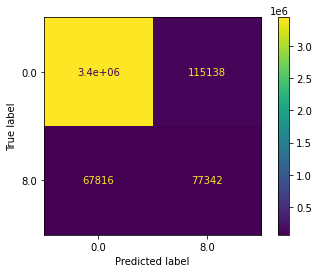

----------------------------------------------------------------------


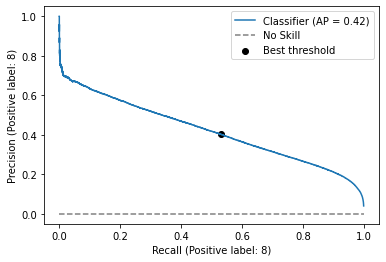

----------------------------------------------------------------------


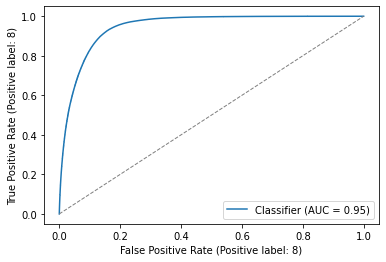

In [12]:
# onlydist
# metrics
clTest = lb.inverse_transform(classes_test)
os.chdir(veremiPath+t2Path+window+lstmPath+model+atk+'/onlydist')
modellstm = keras.models.load_model(veremiPath+t2Path+window+lstmPath+model+atk+'/onlydist')
proba = modellstm.predict(data_test)
# Best threshold
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(clTest, proba[:, 1], pos_label=at)
# convert to f score
np.seterr(divide='ignore', invalid='ignore')
fscore = (2 * precision * recall) / (precision + recall)
np.nan_to_num(fscore, copy=False)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print("-"*70)
# Classification Report
from sklearn.metrics import classification_report
pred = np.where(np.array(proba[:, 1]) >= thresholds[ix], at, 0)
print('Classification Report for md'+str(m)+'lstm'+'at'+str(at)+'onlydist')
print(classification_report(clTest, pred, target_names=['class all', 'class '+str(at)], digits=3, zero_division=0))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# predrelu = lb.inverse_transform(predictsrelu, threshold=thresholds[ix])
cm = confusion_matrix(clTest, pred, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.savefig('md'+str(m)+'lstm'+'at'+str(at)+'onlydist'+'.pdf')
plt.show()
print("-"*70)
# Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(clTest, proba[:, 1], pos_label=at)
# plt.title('PR curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
no_skill = len(clTest[clTest==1]) / len(clTest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', color="grey", label='No Skill')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold')
plt.legend()
plt.savefig('PRcurve '+'md'+str(m)+'lstm'+'at'+str(at)+'onlydist'+'.pdf')
plt.show()
print("-"*70)
# ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(clTest, proba[:, 1], pos_label=at)
# plt.title('ROC curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.savefig('ROCcurve '+'md'+str(m)+'lstm'+'at'+str(at)+'onlydist'+'.pdf')
plt.show()